#### Submitted By: Lior Kricheli, Eliran Malka and Itamar Yacoby

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.metrics import confusion_matrix
from seaborn import heatmap 
import seaborn as sns

print(tf.__version__)

2.3.0


<table>
  <tr>
    <th>Model</th>
    <th>#parameters</th>
    <th>epochs</th>
    <th>train accuracy</th>
    <th>test accuracy</th>
  </tr>
    
  <!-- copy this block once for every model you tested -->  
  <tr> 
    <td>...</td>   <!-- Model -->
    <td>>... </td> <!-- Parameters -->
    <td>>...</td> <!-- epochs -->
    <td>>...</td> <!-- train -->
    <td>>...</td> <!--  test -->
  </tr>

  <tr> 
    <td>>...</td>   <!-- model -->
    <td>>... </td> <!-- parameters -->
    <td>>...</td> <!-- epochs -->
    <td>>...</td> <!-- train -->
    <td>>...</td> <!-- test -->
  </tr>
    
</table>




In [2]:
ls archive\Kather_texture_2016_image_tiles_5000\Kather_texture_2016_image_tiles_5000

 Volume in drive C is Acer
 Volume Serial Number is 96D3-27E0

 Directory of C:\Users\Itamar\Desktop\DeepLearningFinalProject\archive\Kather_texture_2016_image_tiles_5000\Kather_texture_2016_image_tiles_5000

03/06/2021  11:05    <DIR>          .
03/06/2021  11:05    <DIR>          ..
06/06/2021  13:05    <DIR>          train
03/06/2021  11:06    <DIR>          validation
               0 File(s)              0 bytes
               4 Dir(s)  373,809,729,536 bytes free


In [3]:
pathTrain = 'archive\\Kather_texture_2016_image_tiles_5000\\Kather_texture_2016_image_tiles_5000\\train'
pathTest= 'archive\\Kather_texture_2016_image_tiles_5000\\Kather_texture_2016_image_tiles_5000\\validation'
my_batch_size = 32

#Defining data generator WITH pre processing
dataGen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = dataGen.flow_from_directory(pathTrain,
                                              batch_size=my_batch_size, 
                                              class_mode='categorical')

dataGenTest = ImageDataGenerator()
test_generator = dataGenTest.flow_from_directory(pathTest,                                              
                                             batch_size=my_batch_size, 
                                             class_mode='categorical', 
                                             shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


In [4]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))
model.add(GlobalMaxPooling2D())
model.add(Dense(8, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        9

In [5]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 1
history = model.fit(train_generator, steps_per_epoch=train_generator.samples/train_generator.batch_size, 
          validation_data=test_generator,
          epochs=epochs, batch_size=20, verbose=1)


141/140 [==============================] - 400s 3s/step - loss: 2.1123 - accuracy: 0.2271 - val_loss: 1.8142 - val_accuracy: 0.2762


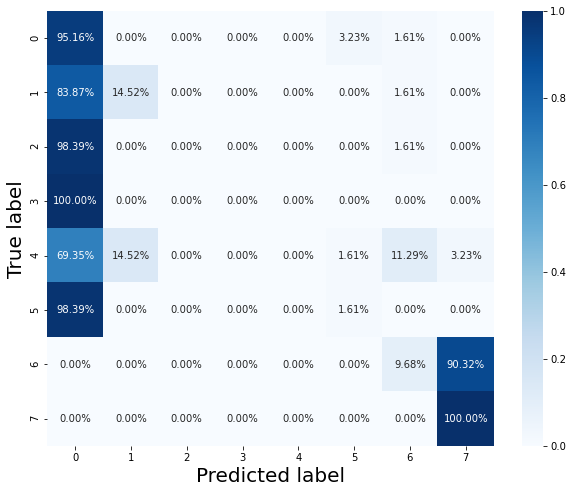

In [12]:
true_labels = test_generator.classes
predictions = model.predict(test_generator)
y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])
cm = confusion_matrix(y_true, y_pred)
CM = cm / cm.sum(axis=1)


plt.figure(figsize=(10,8))
heatmap(CM,cmap='Blues',annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.show()

In [6]:
# model = Sequential()

# model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = (150,150,3)))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())

# model.add(Dense(256,activation = "relu"))          
# model.add(Dense(64,activation = "relu"))
# model.add(Dense(32,activation = "relu"))

# model.add(Dense(9, activation = "softmax"))

# model.summary()

In [7]:
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# epochs = 10
# model.fit(train_generator, steps_per_epoch=train_generator.samples/train_generator.batch_size, 
#           validation_data=test_generator,
#           epochs=epochs, batch_size=20, verbose=1)
